Unfortunately, there are some workarounds required.
```
ln -s vtkm/thirdparty/diy/vtkmdiy/ vtkmdiy
ln -s vtkm/thirdparty/taotuple/vtkmtaotuple/ vtkmtaotuple
```

in the 

```
include/vtkm-1.2
```

installation directory. These are normally handled by the `VTKmTargets.cmake` in

```
lib/cmake/vtkm-1.2/
```


In [1]:
#pragma cling add_include_path("/home/mark/local/vtk-m/clang/include/vtkm-1.2")
#pragma cling add_library_path("/home/mark/local/vtk-m/clang/lib")
//#pragma include_alias("/local/vtk-m/clang/include/vtkm-1.2/vtkm/thirdparty/taotuple/vtkmtaotuple/","vtkmtaotuple")
#pragma cling load("vtkm_cont-1.2")
#pragma cling load("vtkm_rendering-1.2")

#pragma cling add_include_path("/home/mark/local/include/")
#pragma cling add_library_path("/home/mark/local/lib")
#pragma cling load("lodepng")


In [2]:
#include <vtkm/cont/DeviceAdapter.h>
#include <vtkm/cont/testing/MakeTestDataSet.h>
#include <vtkm/cont/testing/Testing.h>
#include <vtkm/rendering/Actor.h>
#include <vtkm/rendering/CanvasRayTracer.h>
#include <vtkm/rendering/MapperRayTracer.h>
#include <vtkm/rendering/Scene.h>
#include <vtkm/rendering/View3D.h>
#include <vtkm/rendering/testing/RenderTest.h>

Use lodepng to save out png instead of pnm so jupyter can read it.


In [3]:
#include <lodepng.h>
template<typename CanvasType>
void savePng(CanvasType &canvas, std::string &fn, int width, int height)
{
  std::vector<std::uint8_t> PngBuffer(width*height*4);

  using ColorBufferType = vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 4>>;

  ColorBufferType::PortalConstControl colorPortal = canvas.GetColorBuffer().GetPortalConstControl();

  for (vtkm::Id yIndex = 0; yIndex < height; yIndex++)
  {
    for (vtkm::Id xIndex = 0; xIndex < width; xIndex++)
    {
      vtkm::Vec<vtkm::Float32, 4> tuple = colorPortal.Get(yIndex * width + xIndex);
      //of << (unsigned char)(tuple[0] * 255);
      //of << (unsigned char)(tuple[1] * 255);
      //of << (unsigned char)(tuple[2] * 255);
        
        std::size_t NewPos = (height - yIndex - 1) * (width * 4) + 4 * xIndex;
        PngBuffer[NewPos + 0] = (unsigned char)(tuple[0] * 255);
        PngBuffer[NewPos + 1] = (unsigned char)(tuple[1] * 255);
        PngBuffer[NewPos + 2] = (unsigned char)(tuple[2] * 255);
        PngBuffer[NewPos + 3] = 255; 

    }
  }
  
std::vector<std::uint8_t> ImageBuffer;
lodepng::encode(ImageBuffer, PngBuffer, width, height);
lodepng::save_file(ImageBuffer, fn.c_str());    
}



In [4]:
template <typename ViewType>
inline void SetCamera(vtkm::rendering::Camera& camera,
                      const vtkm::Bounds& coordBounds,
                      const vtkm::cont::Field& field);

template <>
inline void SetCamera<vtkm::rendering::View3D>(vtkm::rendering::Camera& camera,
                                               const vtkm::Bounds& coordBounds,
                                               const vtkm::cont::Field&)
{
  camera = vtkm::rendering::Camera();
  camera.ResetToBounds(coordBounds);
  camera.Azimuth(static_cast<vtkm::Float32>(45.0));
  camera.Elevation(static_cast<vtkm::Float32>(45.0));
}
template <typename MapperType, typename CanvasType, typename ViewType>
void Render(ViewType& view, const std::string& outputFile)
{
  view.Initialize();
  view.Paint();
  //view.SaveAs(outputFile);
}


In [5]:
using M = vtkm::rendering::MapperRayTracer;
using C = vtkm::rendering::CanvasRayTracer;
using V3 = vtkm::rendering::View3D;
using V2 = vtkm::rendering::View2D;

vtkm::cont::testing::MakeTestDataSet maker;
vtkm::cont::ColorTable colorTable("inferno");

//vtkm::rendering::testing::Render<M, C, V3>(maker.Make3DRegularDataSet0(), "pointvar", colorTable, "rt_reg3D.pnm");

M mapper;
C canvas(512, 512);
vtkm::rendering::Scene scene;
vtkm::cont::DataSet ds = maker.Make3DRegularDataSet0();
static std::string fieldNm = "pointvar";
static std::string outputFile = "rt_reg3D.png";

scene.AddActor(vtkm::rendering::Actor(
ds.GetCellSet(), ds.GetCoordinateSystem(), ds.GetField(fieldNm), colorTable));
vtkm::rendering::Camera camera;
SetCamera<V3>(camera, ds.GetCoordinateSystem().GetBounds(), ds.GetField(fieldNm));
vtkm::rendering::Color background(1.0f, 1.0f, 1.0f, 1.0f);
vtkm::rendering::Color foreground(0.0f, 0.0f, 0.0f, 1.0f);
V3 view(scene, mapper, canvas, camera, background, foreground);

// Print the title
vtkm::rendering::TextAnnotationScreen* titleAnnotation =
new vtkm::rendering::TextAnnotationScreen("Test Plot",
                                          vtkm::rendering::Color(1, 1, 1, 1),
                                          .075f,
                                          vtkm::Vec<vtkm::Float32, 2>(-.11f, .92f),
                                          0.f);
view.AddAnnotation(titleAnnotation);
Render<M, C, V3>(view, outputFile);

savePng(canvas, outputFile, 512,512);


In [6]:
#include <string>
#include <fstream>

#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"

namespace im
{
    struct image
    {
        inline image(const std::string& filename)
        {
            std::ifstream fin(filename, std::ios::binary);
            m_buffer << fin.rdbuf();
        }

        std::stringstream m_buffer;
    };

    nlohmann::json mime_bundle_repr(const image& i)
    {
        auto bundle = nlohmann::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer.str());
        return bundle;
    }
}

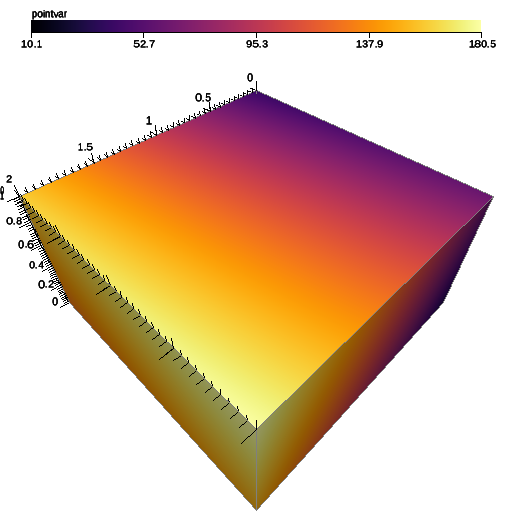

In [7]:
im::image rt_reg3D("rt_reg3D.png");
rt_reg3D